<center>
<h1 style="color:red; font-size:70px;"> Esercitazione 6</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

<h1 style="color: blue; font-size:50px;"> Esercizio 1 - Early stopping</h1>

Contenuto del dataframe


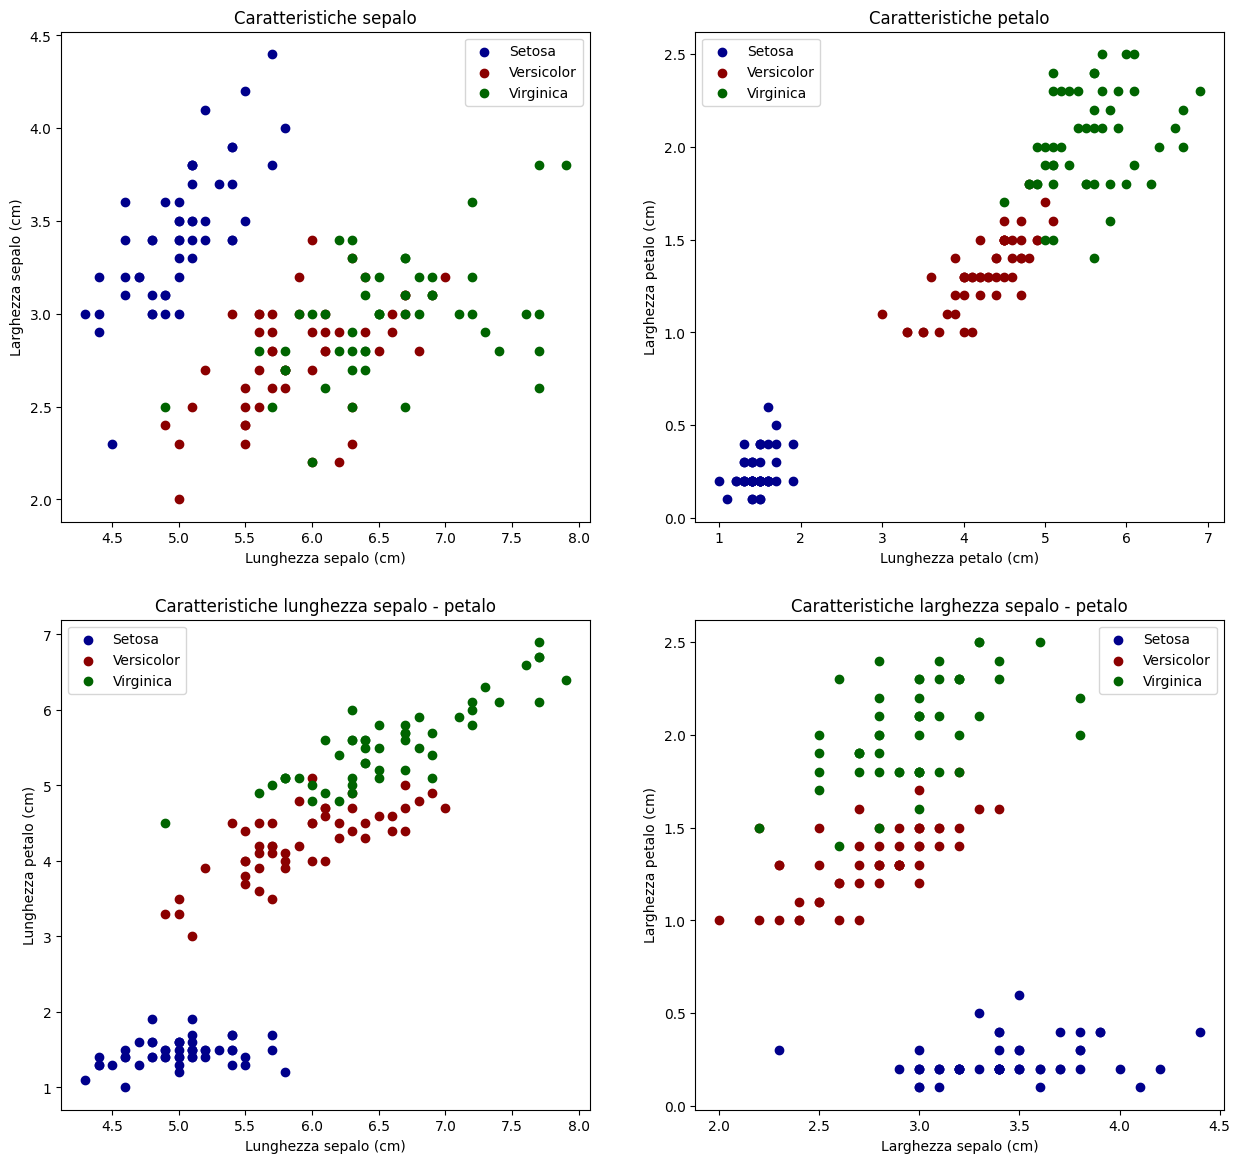

In [10]:
def stampaCorr(asc, ord, titx, tity, titp):
    # Funzione per stampare eventuali correlazioni presenti nel dataset
    fig, ax = plt.subplots(2, 2, figsize = (15, 14))

    # Doppio ciclo per riempire tutti i plot
    for i in range(0, 2):
        for j in range(0, 2):
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 0], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 0], color = 'darkblue', label  = "Setosa")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 1], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 1], color = 'darkred', label  = "Versicolor")
            ax[i][j].scatter(irisDf[iris.feature_names[asc[2*i+j]]][iris.target == 2], irisDf[iris.feature_names[ord[2*i+j]]][iris.target == 2], color = 'darkgreen', label  = "Virginica")
            ax[i][j].set_xlabel(titx[2*i+j])
            ax[i][j].set_ylabel(tity[2*i+j])
            ax[i][j].set_title(titp[2*i+j])
            ax[i][j].legend(loc = 'best')





# La prima fase di questo esercizio consiste nell'importare il dataset IRIS, che
# restitusce un dizionario le cui flag sono:
#       - 'data': matrice con lughezze sepali e petali
#       - 'target': etichetta del fiore corrispondente
#       - 'feature_names': elenco di stringhe per nomi dati
#       - 'target_names': elenco di stringhe per nomi fiori
# In particolare 'data' è un array bidimensionale di forma (150, 4) in cui ogni riga
# rappresenta un fiore, e ogni colonna rappresenta una delle caratteristiche dello stesso. 
# Per ogni fiore sono quindi prese in considerazione 4 features, ossia lunghezza e larghezza
# del sepalo e del petalo.
iris = load_iris()
# Per convertire quanto ottenuto come output della funzione load_iris() in un oggetto di pandas 
# (che è comodo per gestiri tali tipologie di dataset) è possibile specificare nel costruttore 
# del dataFrame i dati contenuti in iris (ossia lunghezza e larghezza di sepali e petali di ciascun 
# fiore) ed i nomi delle colonne.
irisDf = pd.DataFrame(data = iris.data, columns = iris.feature_names)
# In un secondo momento vanno aggiunte delle altre colonne al dataframe, ossia l'etichetta numerica 
# target, che indica la classe di appartenenza del fiore, ed il nome della classe in questione.
# Questa operazione non può essere effettuata in fase di inizializzazione.
irisDf['target'] = iris.target
irisDf['target_name'] = irisDf['target'].apply(lambda i: iris.target_names[i])

# Stampo a video il contenuto del dataframe
print("Contenuto del dataframe")
irisDf

# Stampo a video eventuali correlazioni fra i dati del dataset. Ciò che notiamo è che la classificazione 
# della classe setosa ci possiamo aspettare che sia più semplice rispetto alla distinzione fra le altre due
# classi, poichè si notano degli evidenti cluster riferiti solo alla sottospecie setosa
asc = [0, 2, 0, 1]
ord = [1, 3, 2, 3]
titx = ["Lunghezza sepalo (cm)", "Lunghezza petalo (cm)", "Lunghezza sepalo (cm)", "Larghezza sepalo (cm)"]
tity = ["Larghezza sepalo (cm)", "Larghezza petalo (cm)", "Lunghezza petalo (cm)", "Larghezza petalo (cm)"]
titp = ["Caratteristiche sepalo", "Caratteristiche petalo", "Caratteristiche lunghezza sepalo - petalo", "Caratteristiche larghezza sepalo - petalo"]

stampaCorr(asc, ord, titx, tity, titp)